To get started, we can perform linear regression using linear algebra. Assume a model of $y=\theta_0 + \theta_1 x_1 + \cdots + \theta_n x_n$, where $n$ is the number of features. $\theta_0$ is the bias term. The typical performance metric is mean square error (MSE): $E( \theta )=\frac{1}{m}\sum_{i=1}^m (\theta^T x^{(i)}-y^{(i)})$, where $\theta = [\theta_0 \ \cdots \ \theta_n]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

m = 500

X = 1.6 * np.random.rand(m,1)
y = 1.5 + 2.25 * X + np.random.randn(m,1) # theta_0 = 1.5, theta_1 = 2.25

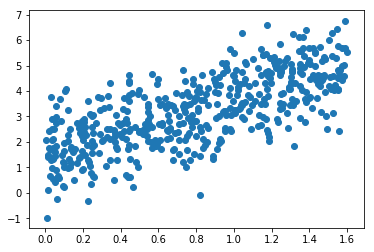

In [2]:
%matplotlib inline
plt.scatter(X,y)
plt.show()

By taking all data instances, $x^{(i)}$, and their target values, $y^{(i)}$, we can compute the parameters using the closed form equation:
$\hat{\Theta}=(X^T\cdot X)^{-1}\cdot X^T\cdot y$

In [3]:
X_b = np.c_[np.ones((500,1)), X] # Adds the bias term, x_0 = 1

In [4]:
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
# We get something pretty close to the function that generated this data.
theta

array([[1.49231085],
       [2.1706725 ]])

In [6]:
# Test the predictions
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

In [7]:
y_predict = X_new_b.dot(theta)
y_predict

array([[1.49231085],
       [5.83365585]])

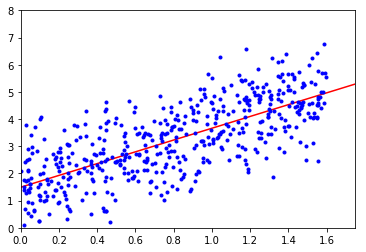

In [8]:
# Plot it
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,1.75,0,8])
plt.show()

In [9]:
# We can do the same with sklearn linear regression.
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X,y)

/Users/pjmartin/Code/python-ml-sandbox/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
print("Model: " + str(linreg.coef_) + "x + " + str(linreg.intercept_))

Model: [[2.1706725]]x + [1.49231085]


In [11]:
linreg.predict(X_new)

array([[1.49231085],
       [5.83365585]])

For data sets with a *large number of *features*, the inversion required to solve the equation becomes very expensive. Instead, *gradient descent* can be applied to adjust parameters, $\theta$. In linear regression, MSE is the typical cost function. We compute the gradient of MSE along each parameter $\theta_j$. Gradient descent searches through the parameter space following the gradient of a convex function.

In [12]:
# Implementation of gradient descent
def gradient_descent(X, y, n_params, eta, tolerance):
    m = len(X)

    # Initialize the parameters to some random value
    theta = np.random.randn(n_params,1)
    # Compute an initial gradient vector
    gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
    
    while np.linalg.norm(gradient_vector) > tolerance:
        # Compute the gradient
        gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - eta * gradient_vector

    return theta

In [13]:
params = gradient_descent(X_b, y, 2, 0.1, 0.001)
print("Final parameters:\n " + str(params))

Final parameters:
 [[1.49485598]
 [2.16789128]]


Nice!

Gradient descent requires the *whole training* set to compute the gradient. This requirement will not scale as the number of instances, $m$, increases. The alternative is to use **stochastic gradient descent**. We lose the smooth convergence guarantees and it will not reach the true optimal value. But, it executes on data point at a time, sometimes allowing quicker convergence to something near the minimum. It is recommended to apply simulated annealing (gradually reduce the step size/learning rate) as you approach the minimum. One approach, shown below, is to set a schedule based on the number of epochs.

In [14]:
n_epochs = 50
t0, t1 = 5, 50 # For the learning schedule

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # again, random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_idx = np.random.randint(m)
        # Slices out the entry at the random index
        xi = X_b[random_idx:random_idx+1]
        yi = y[random_idx:random_idx+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print("Final parameters:\n " + str(theta))

Final parameters:
 [[1.48415383]
 [2.19545269]]


To handle large data sets, we can use mini-batch gradient descent. It snags a random subset of the data and performs a typical gradient descent operation with it. Note my implementation is not great! It does not converge, as shown in the plot.

In [15]:
from sklearn.utils import shuffle

n_epochs = 50
n_batches = 10
batch_size = m / n_batches

theta = np.random.randn(2,1)

eta = 0.01
gradient_norms = []
# For each epoch compute the gradient over the minibatch. Repeat for next batch.
for epoch in range(n_epochs):
    # Shuffle up the data sets and targets
    X_shuffle, y_shuffle = shuffle(X_b, y)        
    start_idx = 0
    stop_idx = int(batch_size - 1)
    for i in range(n_batches):
        X_batch = X_b[start_idx:stop_idx]
        y_batch = y[start_idx:stop_idx]
        gradients = 2 * X_batch.T.dot(X_batch.dot(theta) - y_batch)
        grad_norm = np.linalg.norm(gradients)
        gradient_norms.append(grad_norm)
        # Arbitrary, fixed schedule - it should be something nicer like
        # regular SGD, but anything higher than eta = 0.01 leads to instability
        if grad_norm < 100:
            eta = 0.005
        theta = theta - eta * gradients
        start_idx = int(stop_idx + 1)
        stop_idx = int(stop_idx + batch_size)

print("Final parameters:\n " + str(theta))

Final parameters:
 [[1.56036944]
 [2.18018586]]


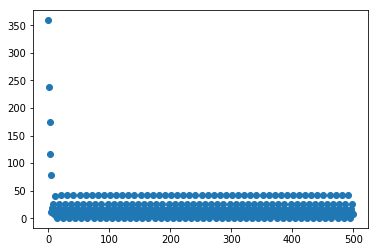

In [16]:
idxs = range(0,len(gradient_norms))
plt.scatter(idxs,gradient_norms)
plt.show()

Anywho - the lackluster attempt at mini-batch SGD distracted from polynomial regression! If the data is clearly nonlinear, the features can be manipulated to perform linear regression on polynomial basis functions.

In [17]:
X = 5 * np.random.rand(m, 1) - 3
y = 0.85 * X**2 + 3*X + 1 + np.random.randn(m,1)

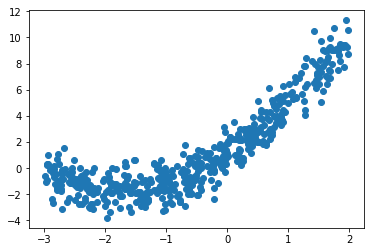

In [18]:
plt.scatter(X,y)
plt.show()

In [19]:
# Transform the features into polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [20]:
print("Original feature sample: " + str(X[0]))
print("...and it's 2nd order version: " + str(X_poly[0]))

Original feature sample: [-0.0843464]
...and it's 2nd order version: [-0.0843464   0.00711432]


In [21]:
# Simply apply linear regression now
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
print("Coefficients: " + str(lin_reg.coef_))
print("y-Intercept: " + str(lin_reg.intercept_))

Coefficients: [[3.00423548 0.84118502]]
y-Intercept: [1.05708079]


Also pretty good! Note that for data with multiple features, PolynomialFeatures will compute their combinations but that is a combinatoric process!

## Learning  Curves
We use learning curves to get more information about the fit of our chosen regression models. The code below will take an input data set, $X$, and its targets, $y$, and produce a plot of the mean squared error over size of data set used.

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors = []
    val_errors = []
    
    # Train and predict for data sets from 1 to the size of the training set
    for i in range(1, len(X_train)):
        X_curr = X_train[:i]
        y_curr = y_train[:i]
        model.fit(X_curr, y_curr)
        # Make a prediction using this training set
        y_train_pred = model.predict(X_curr)
        # Predict the result of using the whole validation set
        y_val_pred = model.predict(X_val)
        
        train_errors.append( mean_squared_error(y_train_pred, y_curr) )
        val_errors.append( mean_squared_error(y_val_pred, y_val) )
    
    plt.plot(np.sqrt( train_errors ), "r--+", linewidth=2, label="Training data")
    plt.plot(np.sqrt( val_errors ), "b-", linewidth=3, label="Validation data")
    plt.xlim(xmin=0, xmax=len(X_train)+2)
    plt.ylim(ymin=0, ymax=3)
    plt.show()

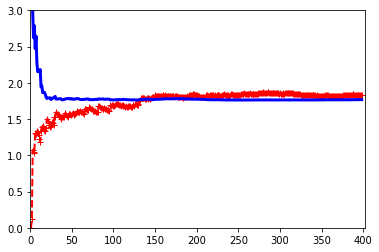

In [24]:
# Using the function above, look at how a vanilla linear regression behaves.
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

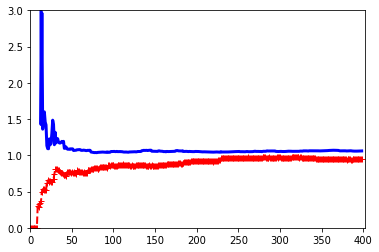

In [25]:
# The plateau and relatively high RMSE indicates underfitting, which is expected for a linear
# model fit to nonlinear data. Try Polynomial...
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=8, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

The higher order polynomials have reduced error, but there  is still a gap meaning that it is overfitting. A second order fits the best as we should expect. Ifyou supplied more training data a higher order model would perform better on the validation set.

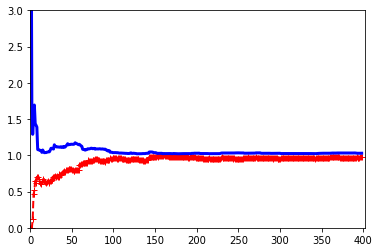

In [26]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

## Regulariztion
Another method to reduce sensitivity and overfitting is to add penalties to the weights, $\theta$, in regression operations. This process is *regularization*. Two common regularization technniques are $l_2$ and $l_1$, which are named after the norms used in the weight penalty term.

In [27]:
# RidgeRegression implements an l2-norm based regularization. 
# Its stochastic gradient descent cousin is SGDRegressor.
# This example will re-use the 2nd order polynomial features, X_poly
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X_poly, y)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [28]:
print("Coefficients: " + str(ridge_reg.coef_))
print("y-Intercept: " +str(ridge_reg.intercept_))

Coefficients: [[3.00362805 0.84093068]]
y-Intercept: [1.05728758]


In [29]:
# And apply the SGD Regressor
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2", tol=1e-3)
sgd_reg.fit(X_poly, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False)

In [30]:
print("Coefficients: " + str(sgd_reg.coef_))
print("y-Intercept: " +str(sgd_reg.intercept_))

Coefficients: [2.97562838 0.82707334]
y-Intercept: [1.04744363]


In [31]:
# Lasso regression uses the l1 norm instead. You can use the SGDRegressor as well using the penalty="l1"
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_poly, y)
print("Coefficients: " + str(lasso_reg.coef_))
print("y-Intercept: " +str(lasso_reg.intercept_))

Coefficients: [2.99153755 0.83472644]
y-Intercept: [1.06392889]


In [32]:
sgd_reg_l1 = SGDRegressor(penalty="l1", tol=1e-3)
sgd_reg_l1.fit(X_poly, y.ravel())
print("Coefficients: " + str(sgd_reg_l1.coef_))
print("y-Intercept: " +str(sgd_reg_l1.intercept_))

Coefficients: [3.0013861  0.82792988]
y-Intercept: [1.04264916]


In [33]:
# Elastic Net gives you the best of both worlds. It mixes l2 and l1 regularization using a ratio r.
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_reg.fit(X_poly, y)
print("Coefficients: " + str(elastic_reg.coef_))
print("y-Intercept: " + str(elastic_reg.intercept_))

Coefficients: [2.80036936 0.75035163]
y-Intercept: [1.13858542]


## Logistic Regression
Regression may be used to classify using the sigmoid function
$$
\sigma(t) = \frac{1}{1+e^{-t}}, t\in \mathbb{R}
$$
The range of $\sigma$ is on $[0,1]$, hence we use it to compute the probability of an input being in a class. *Logistic regression* computes the weighted sum of the input features and outputs its *logistic*, which is computed by $\sigma$:
$$
    p = \sigma(\theta^T \cdot x)
$$
Training logistic regression models requires minimizing the *log-loss* function, which is convex but does not have an analytical solution for $\theta$. As a convex function, we can use gradient descent methods to find the minimum.

In [34]:
# Example of logistic regression on the iris data set
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [35]:
# Extract only the type feature for prediction: petal width
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int)

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

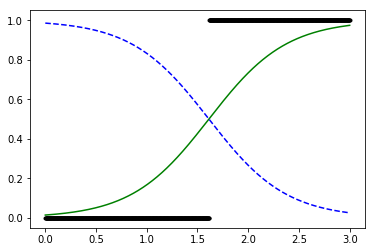

In [37]:
# Make predictions and plot the probability of being in the class.
X_new = np.linspace(0,3,1000).reshape(-1,1)
X_new.shape
y_proba = log_reg.predict_proba(X_new)
y_class = log_reg.predict(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label="Iris-Virginica")
plt.plot(X_new, y_proba[:,0], 'b--', label="Not Iris-Virginica")
plt.plot(X_new, y_class, 'k.')
plt.show()

To perform *multiclass* regression, we use the *softmax* measure. Softmax takes a collection of class scores, $s_k(x) = \theta^{(k)T}\cdot x$, and computes the probability of $x$ being in class $k$.
$$
    p_k = \frac{exp(s_k(x))}{\sum_{j=1}^K exp(s_j(x))}
$$

In [38]:
def softmax(scores):
    sum_of_exp = np.sum( np.exp(scores) )
    return np.exp(scores) / sum_of_exp

In [39]:
# Test it out with arbitrary data
dummy_scores = np.array([1, 6, 0.5])

In [40]:
# In this silly example, the class with a score of six will have the highest probability.
prob_classes = softmax(dummy_scores)
print("Softmax = " + str(prob_classes))

Softmax = [0.00666579 0.9892912  0.00404301]


Mutlinomial/multiclass regression uses softmax for computing the probabilities and the cross entropy to compute the loss when training $\theta$. Note that $\Theta$ is a parameter matrix - where each class ($k \in K$) has its own $\theta^{(k)}$
$$
J(\Theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{K} y_k^{(i)}log(p_k^{(i)})
$$

In [41]:
# Extract iris petal length AND width
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10) # C = 1/alpha
softmax_reg.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
# Predict for an iris with 4cm long and 2cm wide petals
y_pred = softmax_reg.predict([[4, 2]])
y_prob = softmax_reg.predict_proba([[4, 2]])
print("Predicted class = " + str(y_pred) + " with probabilities " + str(y_prob))

Predicted class = [1] with probabilities [[0.00102836 0.81204487 0.18692677]]


Here is a visualization of the classifier across some ranges of petal length and width.

In [43]:
# Data points for visualization
l, w = np.meshgrid(np.linspace(0,8,500).reshape(-1,1),
                             np.linspace(0,4,250).reshape(-1,1))
X_new = np.c_[l.ravel(), w.ravel()]
y_pred = softmax_reg.predict(X_new)
X_new.shape

(125000, 2)

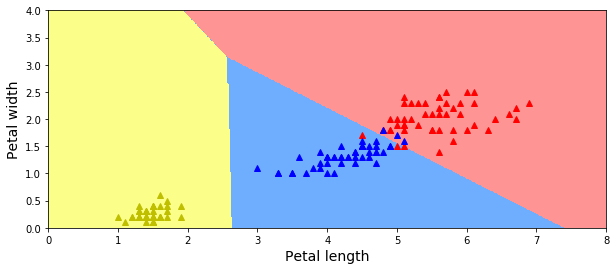

In [47]:
from matplotlib.colors import ListedColormap

# True length and width data 
iris_virg_lengths, iris_virg_widths = X[y==2, 0], X[y==2, 1]
iris_vers_lengths, iris_vers_widths = X[y==1, 0], X[y==1, 1]
iris_setosa_lengths, iris_setosa_widths = X[y==0, 0], X[y==0, 1]

plt.figure(figsize=(10,4))
# Plot the individual points
plt.plot(iris_virg_lengths, iris_virg_widths, "r^", label="Iris Virginica")
plt.plot(iris_vers_lengths, iris_vers_widths, "b^", label="Iris Virginica")
plt.plot(iris_setosa_lengths, iris_setosa_widths, "y^", label="Iris Virginica")

# Create the contour plot for nice visualization
iris_cmap = ListedColormap(["#FBFF8A", "#6FAEFF", "#FF9494"])
contour_z = y_pred.reshape(w.shape)
plt.contourf(l, w, contour_z, cmap=iris_cmap)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)

plt.axis([0,8,0,4])
plt.show()